# Runtime Analys of IMDb dataset

Let's imagine directors and producers of a new movie, who want it to be a hit. For it, they need to determine ideal factors using data, on of which is movie length or runtime. Using correlation of success and runtime, it is possible to determine perfect movie lengths for each genre and time period!

Criteria of success are good ratings and received oscar awards.

[Oscar awards dataset source](https://www.kaggle.com/datasets/unanimad/the-oscar-award)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from enum import Enum


In [2]:
pd.set_option('display.max_rows', 10000)

First, lets select only movies

In [3]:
all_df = pd.read_csv('../imdb/cleaned-imdb-dataset.csv')

In [4]:
movies_raw = all_df[all_df['titleType'] == 'movie']
del all_df
movies_raw.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,NaN,45.0,Romance,5.3,210.0
146,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897.0,NaN,100.0,"Documentary,News,Sport",5.2,509.0
501,tt0000502,movie,Bohemios,Bohemios,0,1905.0,NaN,100.0,NaN,4.2,16.0
573,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,NaN,70.0,"Action,Adventure,Biography",6.0,882.0
590,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907.0,NaN,90.0,Drama,5.4,24.0


The resulting dataFrame contains all feature movies. But it also contains irrelevant rows, including titleType, which contains the same value

In [5]:
movies_raw = movies_raw.drop(columns=['titleType', 'isAdult', 'endYear', 'originalTitle'])
movies_raw.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,Miss Jerry,1894.0,45.0,Romance,5.3,210.0
146,tt0000147,The Corbett-Fitzsimmons Fight,1897.0,100.0,"Documentary,News,Sport",5.2,509.0
501,tt0000502,Bohemios,1905.0,100.0,NaN,4.2,16.0
573,tt0000574,The Story of the Kelly Gang,1906.0,70.0,"Action,Adventure,Biography",6.0,882.0
590,tt0000591,The Prodigal Son,1907.0,90.0,Drama,5.4,24.0


Additionally, all rows that have no rating or runtime should also be removed, since they miss critical information

In [6]:
movies_raw = movies_raw[~(movies_raw['averageRating'].isna() | movies_raw['runtimeMinutes'].isna())]

Finally, movies with few votes are not popular enough to be bring value to the analysis, and the small number of votes means that individual votes have a higher impact, leading to raitng to be less reliable. For this reason, only movies with over 3000 votes will be considereded, which leaves 23 thousand movies out of more than 200 thousand.

In [32]:
movies = movies_raw[movies_raw['numVotes'] >= 3000]
movies.count()


tconst            22699
primaryTitle      22699
startYear         22699
runtimeMinutes    22699
genres            22698
averageRating     22699
numVotes          22699
dtype: int64

With cleared movies, we can start the analysis. First, it may be helpful to see if there are any obvious movie lengths that are popular and may be the answers

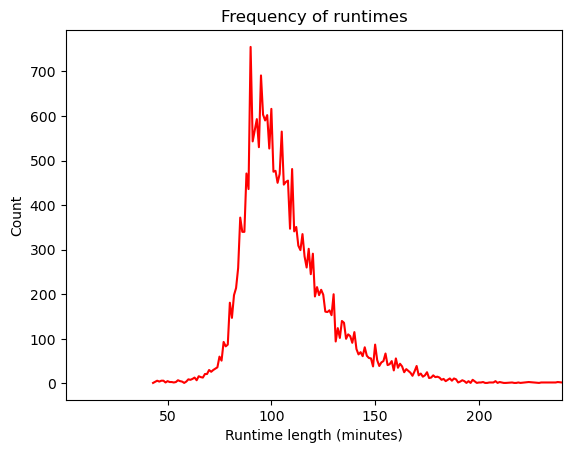

In [129]:
runtime_popularity = movies['runtimeMinutes'].value_counts().sort_index()

plt.xlim(1, 240)
plt.plot(runtime_popularity, color="red")
plt.ylabel('Count')
plt.xlabel('Runtime length (minutes)')
plt.title('Frequency of runtimes')
plt.show()

According to the plot, significant majority of the films have around 90-100 minutes of duration. Sudden spikes are connected with the fact that the data about old films is given in the closest multiply of 5 (for 93 minute film 95 or 90 will be written)

Similarly, a very rough correlation between runtime and rating can be given, by showing average runtime each rating point has

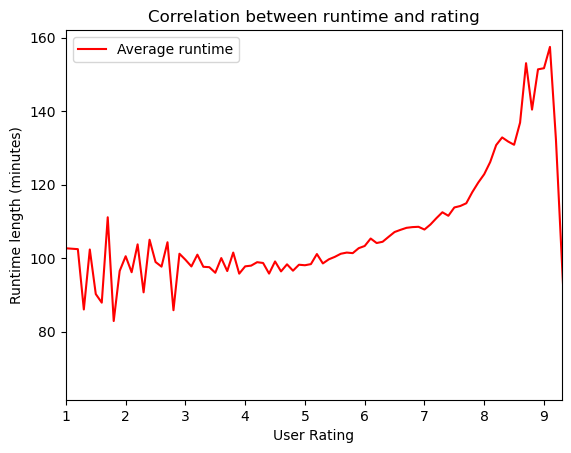

In [137]:
runtime_rating = movies.groupby('averageRating')['runtimeMinutes'].mean()
plt.plot(runtime_rating, color="red", label="Average runtime")
plt.xlabel('User Rating')
plt.ylabel('Runtime length (minutes)')
plt.title('Correlation between runtime and rating')
plt.legend()
plt.xlim(1, 9.3)
plt.show()

Here we can see a completely different, contradicting picture. While 90 minutes was the most popular length, it correlates with the smallest rating. Movies with ratings from 8 to 10, however, have much longer runtimes with 130-160 minutes. Both the large range of 30 minutes and the zigzag-like shape at the end hint that highly successful movies have relatively diverse lengths and that further investigation is necessary. The length drops after 9 because there are very few films in the IMDb databas that have 9+ rating and over 3000 votes

## Runtime and Ratings correlation by year

The next step in our analysis is an attempt to see how popular and successful runtimes change over time.
For this step, we also need to use data of academy awards winning films.

In [43]:
oscars = pd.read_csv('the_oscar_award.csv')
oscars.head()


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [44]:
best_picture_aliases = ['OUTSTANDING PICTURE', 'OUTSTANDING MOTION PICTURE', 'OUTSTANDING PRODUCTION', 'BEST MOTION PICTURE', 'BEST PICTURE']
best_pictures = oscars[oscars['category'].isin(best_picture_aliases)]

best_pictures.tail()

,year_film,year_ceremony,ceremony,category,name,film,winner
10845,2023,2024,96,BEST PICTURE,"Bradley Cooper, Steven Spielberg, Fred Berner,...",Maestro,False
10846,2023,2024,96,BEST PICTURE,"Emma Thomas, Charles Roven and Christopher Nol...",Oppenheimer,True
10847,2023,2024,96,BEST PICTURE,"David Hinojosa, Christine Vachon and Pamela Ko...",Past Lives,False
10848,2023,2024,96,BEST PICTURE,"Ed Guiney, Andrew Lowe, Yorgos Lanthimos and E...",Poor Things,False
10849,2023,2024,96,BEST PICTURE,"James Wilson, Producer",The Zone of Interest,False


Resulting dataframe has the names of all films hat has been nominated or received the Best Picture award. It can be joined with the data about runtimes so determine the lengths such succesful movies had

In [45]:
best_pictures['title_lowercase'] = best_pictures['film'].str.lower()
movies['title_lowercase'] = movies['primaryTitle'].str.lower()

best_picture_runtimes_raw = pd.merge(movies, best_pictures, 'inner', 'title_lowercase')
best_picture_runtimes_raw.head()


/var/folders/cj/1q3301cj5435wzpyw_xn5nhr0000gp/T/ipykernel_1646/1151217773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_pictures['title_lowercase'] = best_pictures['film'].str.lower()
/var/folders/cj/1q3301cj5435wzpyw_xn5nhr0000gp/T/ipykernel_1646/1151217773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['title_lowercase'] = movies['primaryTitle'].str.lower()


,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,title_lowercase,year_film,year_ceremony,ceremony,category,name,film,winner
0,tt0018379,7th Heaven,1927.0,110.0,"Drama,Romance",7.6,4133.0,7th heaven,1927,1928,1,OUTSTANDING PICTURE,Fox,7th Heaven,False
1,tt0018578,Wings,1927.0,144.0,"Action,Drama,Romance",7.5,14465.0,wings,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings,True
2,tt0019729,The Broadway Melody,1929.0,100.0,"Drama,Musical,Romance",5.6,7970.0,the broadway melody,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,The Broadway Melody,True
3,tt0020629,All Quiet on the Western Front,1930.0,152.0,"Drama,War",8.1,67537.0,all quiet on the western front,1929,1930,3,OUTSTANDING PRODUCTION,Universal,All Quiet on the Western Front,True
4,tt0020629,All Quiet on the Western Front,1930.0,152.0,"Drama,War",8.1,67537.0,all quiet on the western front,2022,2023,95,BEST PICTURE,"Malte Grunert, Producer",All Quiet on the Western Front,False


As movie names are not unique, the second parameter to filter by is the year of release. For some reason, the year of release for the same film may be different in two databases, so 2 will be used for the threshold of differences. As a result, we will find 590 awarded films with runtimes out of 601

In [46]:
best_picture_runtimes_raw['year_difference'] = abs(best_picture_runtimes_raw['startYear'] - best_picture_runtimes_raw['year_film'])
best_picture_runtimes = best_picture_runtimes_raw[best_picture_runtimes_raw['year_difference'] <= 2]
print(f'with runtimes: {best_picture_runtimes.count()[0]}, all recepients {best_pictures.count()[0]}')

with runtimes: 543, all recepients 601


/var/folders/cj/1q3301cj5435wzpyw_xn5nhr0000gp/T/ipykernel_1646/1880116178.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'with runtimes: {best_picture_runtimes.count()[0]}, all recepients {best_pictures.count()[0]}')
/var/folders/cj/1q3301cj5435wzpyw_xn5nhr0000gp/T/ipykernel_1646/1880116178.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'with runtimes: {best_picture_runtimes.count()[0]}, all recepients {best_pictures.count()[0]}')


/var/folders/cj/1q3301cj5435wzpyw_xn5nhr0000gp/T/ipykernel_1646/3387038465.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top20_movies_yearly_median = movies.groupby('startYear').apply(lambda group: group.nlargest(20, 'averageRating')['runtimeMinutes'].median())


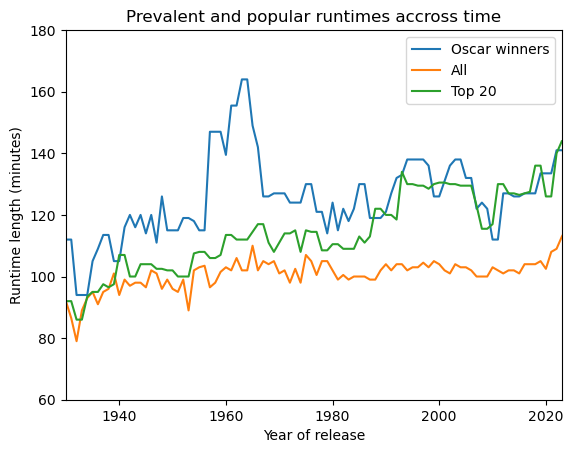

In [142]:
def smoothen(df: pd.DataFrame, window = 3):
  return df.rolling(window=window, min_periods=1).median()

best_pictures_yearly_median = best_picture_runtimes.groupby('year_film')['runtimeMinutes'].median()
plt.plot(smoothen(best_pictures_yearly_median), label="Oscar winners")

all_runtimes_yearly_median = movies.groupby('startYear')['runtimeMinutes'].median()
plt.plot(all_runtimes_yearly_median, label='All')

top20_movies_yearly_median = movies.groupby('startYear').apply(lambda group: group.nlargest(20, 'averageRating')['runtimeMinutes'].median())
plt.plot(smoothen(top20_movies_yearly_median), label="Top 20")

plt.xlim(1930, 2023)
plt.ylim(60, 180)
plt.legend()
plt.ylabel('Runtime length (minutes)')
plt.xlabel('Year of release')
plt.title("Prevalent and popular runtimes accross time")
plt.show()

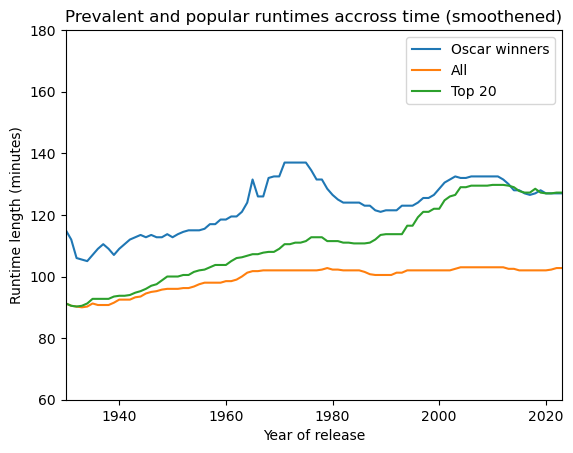

In [143]:
window = 20

plt.plot(smoothen(best_pictures_yearly_median, window), label="Oscar winners")
plt.plot(smoothen(all_runtimes_yearly_median, window), label='All')
plt.plot(smoothen(top20_movies_yearly_median, window), label="Top 20")

plt.xlim(1930, 2023)
plt.ylim(60, 180)
plt.legend()
plt.ylabel('Runtime length (minutes)')
plt.xlabel('Year of release')
plt.title("Prevalent and popular runtimes accross time (smoothened)")
plt.show()

And here is a smoothened version of the graph, to make the changes more visible overtime 

Few suggestions can be made from this.
1. Movies longer than 3 hours are not frequent enough to become the mainstream.
2. The average length of all and best movies has increased, with the latter increasing longer.
3. Longer movies almost always have been more popular, except before 1950s, where we have little data and can't use the same metrics
4. Today, the best movie length is over 2 hours.

However, when I tried to have a forth line - the best movie per year, Documentaries that receive high grades were outliers with over 10 hours for some. This leads to thinking that different genres will have significantly different runtimes



## Runtime and Ratings correlation by Genre

Next step is to determine the best runtime for each genre

In [117]:
class Genre(Enum):
  action = 'Action'
  animation = 'Animation'
  comedy = 'Comedy'
  documentary = 'Documentary'
  drama = 'Drama'
  fantasy = 'Fantasy'
  horror = 'Horror'
  romance = 'Romance'
  scifi = 'Sci-Fi'

def filter_by_genres(genre: Genre):
  return movies[movies['genres'].str.contains(genre.value, na=False)]

Storing runtime averages in a dictionary of arrays

In [118]:
runtimes_per_genre = {}

for genre_label in Genre:
  genre_df = filter_by_genres(genre_label)
  top5 = genre_df.nlargest(5, 'averageRating')['runtimeMinutes'].mean()
  top20 = genre_df.nlargest(20, 'averageRating')['runtimeMinutes'].mean()
  top200 = genre_df.nlargest(200, 'averageRating')['runtimeMinutes'].mean()
  all = genre_df['runtimeMinutes'].mean()
  runtimes_per_genre[genre_label.value] = [ top5, top20, top200, all]

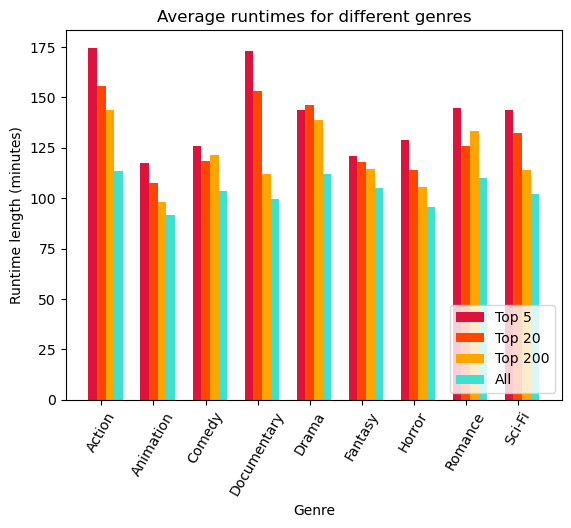

In [144]:
x = np.arange(len(Genre)) * 30

colors = ['crimson', 'orangered', 'orange', 'turquoise']

for genre_index, genre_data in enumerate(runtimes_per_genre.values()):
  for data_index, item in enumerate(genre_data):

    plt.bar(x[genre_index] + data_index*5, item, width=5, color=colors[data_index])

plt.xticks(x + 5, [g.value for g in Genre], rotation=60)

legend_elements = [Patch(facecolor=colors[i], label=label) for i, label in enumerate(["Top 5", "Top 20", "Top 200", "All"])]

plt.legend(handles=legend_elements, loc="lower right")
plt.ylabel('Runtime length (minutes)')
plt.xlabel('Genre')
plt.title("Average runtimes for different genres")
plt.show()



As we can see from the plot, nearly all genres favor longer runtimes. Unsurprisingly, runtimes of action movies are the highest among genres, while animated features and comedies are relatively shorter. In dramas and comedies, runtime is a weaker success factor compared to, for example, science fictions or horrors. The large positive runtime-rating correlation in case of documentaries seems surprising, as documentaries usually not shown in theaters, and there is no standard runtime duration for them, leading us to think that popular documentaries would be shorter or there would be no correlation

But these findings are for movies produced over a century, and recent movie runtimes are more relevant for filmmakers today.

In [120]:
def filter_by_years(df, start, end=2025):
  return df[ (df['startYear'] >= start) & (df['startYear'] <= end)]

top_n = 20
time_comparison_per_genre = []

for genre_label in Genre:
  genre_df = filter_by_genres(genre_label)
  alltime_top = genre_df.nlargest(top_n, 'averageRating')['runtimeMinutes'].mean()
  contemporary_top = filter_by_years(genre_df, 2015).nlargest(top_n, 'averageRating')['runtimeMinutes'].mean()
  time_comparison_per_genre.append(alltime_top)
  time_comparison_per_genre.append(contemporary_top)

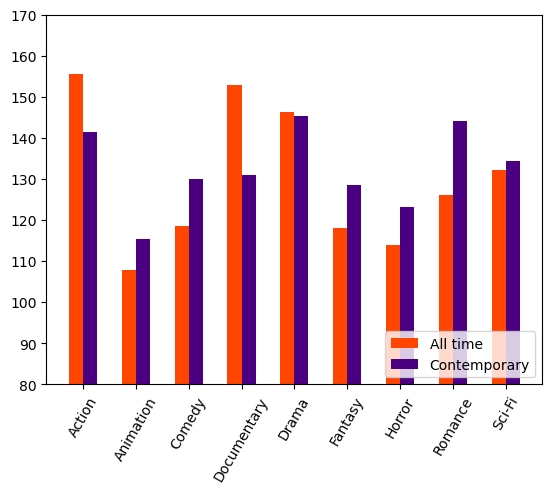

In [121]:
x = np.arange(len(Genre)) * 30

colors = ['orangered', 'indigo']

for index, data in enumerate(time_comparison_per_genre):
    is_contemporary = index%2==1
    plt.bar(x[index//2] + (8 if is_contemporary else 0), data, width=8, color=colors[index%2])

plt.xticks(x + 4, [g.value for g in Genre], rotation=60)

legend_elements = [Patch(facecolor=colors[i], label=label) for i, label in enumerate(["All time", "Contemporary"])]

plt.legend(handles=legend_elements, loc="lower right")
plt.ylim(80, 170)
plt.show()


We previously discovered that over time, runtimes of popular movies tended to increase, but apparently that is not the case for every genre. While differences between all-time and contemporary top 20 movies are not that significant, there are noticeable increases in romance, comedy and fantasy genres, and decreases in action and documentary

## Runtime changes over time across different genres

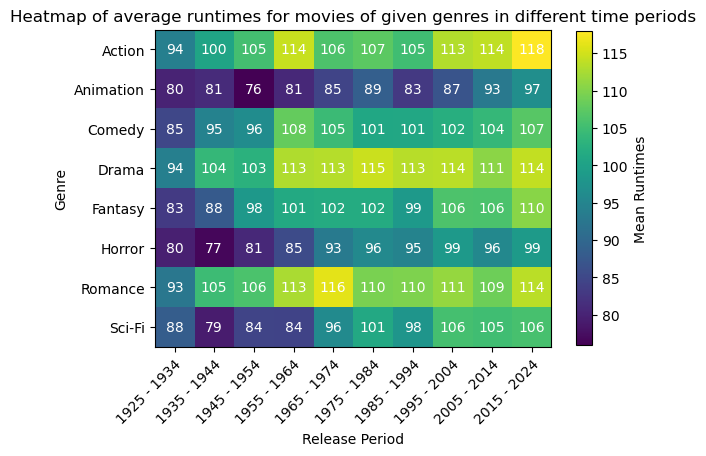

In [157]:
year_period_tuples = [(1925, 1934), (1935, 1944), (1945, 1954), (1955, 1964), (1965, 1974), (1975, 1984), (1985, 1994), (1995, 2004), (2005, 2014), (2015, 2024)]

period_labels = [f'{tuple[0]} - {tuple[1]}' for tuple in year_period_tuples]
genre_labels = [genre.value for genre in Genre if genre != Genre.documentary]

df_per_genre = [filter_by_genres(genre) for genre in Genre if genre != Genre.documentary]

# matrix of mean runtimes separated
mean_runtimes_per_genre_per_period = []

for genre_df in df_per_genre:
  this_genre_runtimes = []
  for tuple in year_period_tuples:
    filtered_genre_df = filter_by_years(genre_df, *tuple)
    this_genre_runtimes.append(filtered_genre_df['runtimeMinutes'].mean())
  mean_runtimes_per_genre_per_period.append(this_genre_runtimes)

mean_runtimes_per_genre_per_period = np.array(mean_runtimes_per_genre_per_period)

fig, ax = plt.subplots()
im = ax.imshow(mean_runtimes_per_genre_per_period)


ax.set_xticks(np.arange(len(period_labels)))
ax.set_yticks(np.arange(len(genre_labels)), labels=genre_labels)
ax.set_xticklabels(period_labels, rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(genre_labels)):
    for j in range(len(period_labels)):
        text = ax.text(j, i, round(mean_runtimes_per_genre_per_period[i, j]),
                       ha="center", va="center", color="w")

fig.colorbar(im, shrink=.85).set_label('Mean Runtimes')
plt.ylabel('Genre')
plt.xlabel('Release Period')
plt.title("Heatmap of average runtimes for movies of given genres in different time periods")
plt.show()

This heatmap highlites the typical runtimes differences for each genre. While the average lengths for dramas and horrors have stayed stable, sci-fi, fantasy and action movies have significantly changed their runtimes over time

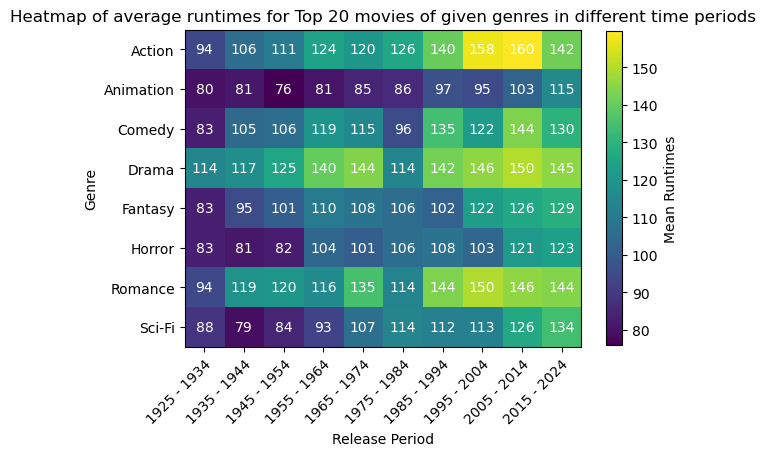

In [159]:
mean_top20_runtimes_per_genre_per_period = []

for genre_df in df_per_genre:
  this_genre_runtimes = []
  for tuple in year_period_tuples:
    filtered_genre_df = filter_by_years(genre_df, *tuple)
    this_genre_runtimes.append(filtered_genre_df.nlargest(20, 'averageRating')['runtimeMinutes'].mean())
  mean_top20_runtimes_per_genre_per_period.append(this_genre_runtimes)

mean_top20_runtimes_per_genre_per_period = np.array(mean_top20_runtimes_per_genre_per_period)


fig, ax = plt.subplots()
im = ax.imshow(mean_top20_runtimes_per_genre_per_period)


ax.set_xticks(np.arange(len(period_labels)))
ax.set_yticks(np.arange(len(genre_labels)), labels=genre_labels)
ax.set_xticklabels(period_labels, rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(genre_labels)):
    for j in range(len(period_labels)):
        text = ax.text(j, i, round(mean_top20_runtimes_per_genre_per_period[i, j]),
                       ha="center", va="center", color="w")

fig.colorbar(im, shrink=.85).set_label('Mean Runtimes')
plt.ylabel('Genre')
plt.xlabel('Release Period')
plt.title("Heatmap of average runtimes for Top 20 movies of given genres in different time periods")
plt.show()

A similar plot, but only for top 20 movies shows a different picture, with nearly all genres increasing their lengths over the last three decades. Perhaps, the optimal runtime for each movies of each genre are demonstraded on the last column